In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as mcolors
METHODS = ['Base', 'Origin', 'Quant', 'ARKV']
METHOD_ORDER = {"Base": 0, "Origin": 1, "Quant": 2, "ARKV": 3}
# Pleasant gradients: lighter at 512 → darker at 2048
MPL_COLORS = {
    "Base": "#D82E83",  # base color
    "Origin_512": "#8FD19E",  # light green
    "Origin_1024": "#4CAF50",  # medium green
    "Origin_2048": "#2E7D32",  # dark green
    "Quant_512": "#F6B26B",   # light orange
    "Quant_1024": "#F39C12",  # medium orange
    "Quant_2048": "#B85C00",  # dark orange
    "ARKV_512": "#7FC8E7",    # light blue
    "ARKV_1024": "#3498DB",   # medium blue
    "ARKV_2048": "#1B5E7A"    # dark blue
}
# SNS_PALETTE = [MPL_COLORS[m] for m in METHODS]

In [ ]:
short_perf = pd.read_csv('data/eval_perf.csv')
gsm8k_perf = short_perf[short_perf['task_type'] == 'GSM8K'].copy()
gsm8k_perf['task'] = gsm8k_perf['task_type']
model_mapping = {
    'Llama-3.2-3B-Instruct': 'Llama-3.2-3B', 
    'Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B', 
    'Qwen3-4B': 'Qwen3-4B',
    'Qwen3-8B': 'Qwen3-8B'
}
gsm8k_perf['model_name'] = gsm8k_perf['model'].map(model_mapping)
gsm8k_perf.head()

,model,method,budget,task,task_type,performance,model_name
1,Llama-3.2-3B-Instruct,ARKV,512,GSM8K,GSM8K,46.02,Llama-3.2-3B
4,Llama-3.2-3B-Instruct,ARKV,1024,GSM8K,GSM8K,64.06,Llama-3.2-3B
7,Llama-3.2-3B-Instruct,ARKV,2048,GSM8K,GSM8K,63.84,Llama-3.2-3B
10,Llama-3.2-3B-Instruct,Base,512,GSM8K,GSM8K,64.97,Llama-3.2-3B
13,Llama-3.2-3B-Instruct,Origin,512,GSM8K,GSM8K,43.67,Llama-3.2-3B


In [13]:
plot_df = gsm8k_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(str)
)
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
model_mb

method_budget,ARKV_1024,ARKV_2048,ARKV_512,Base,Origin_1024,Origin_2048,Origin_512,Quant_1024,Quant_2048,Quant_512
model_name,,,,,,,,,,
Llama-3.1-8B,78.24,78.01,74.37,77.03,77.03,77.86,72.55,53.37,77.79,0.23
Llama-3.2-3B,64.06,63.84,46.02,64.97,63.46,64.97,43.67,47.16,64.90,0.91
Qwen3-4B,83.62,84.46,71.34,84.38,83.62,85.75,74.68,29.04,84.46,1.36
Qwen3-8B,89.46,88.63,86.96,88.78,87.72,88.40,87.49,30.63,87.64,1.67


<Figure size 1400x700 with 0 Axes>

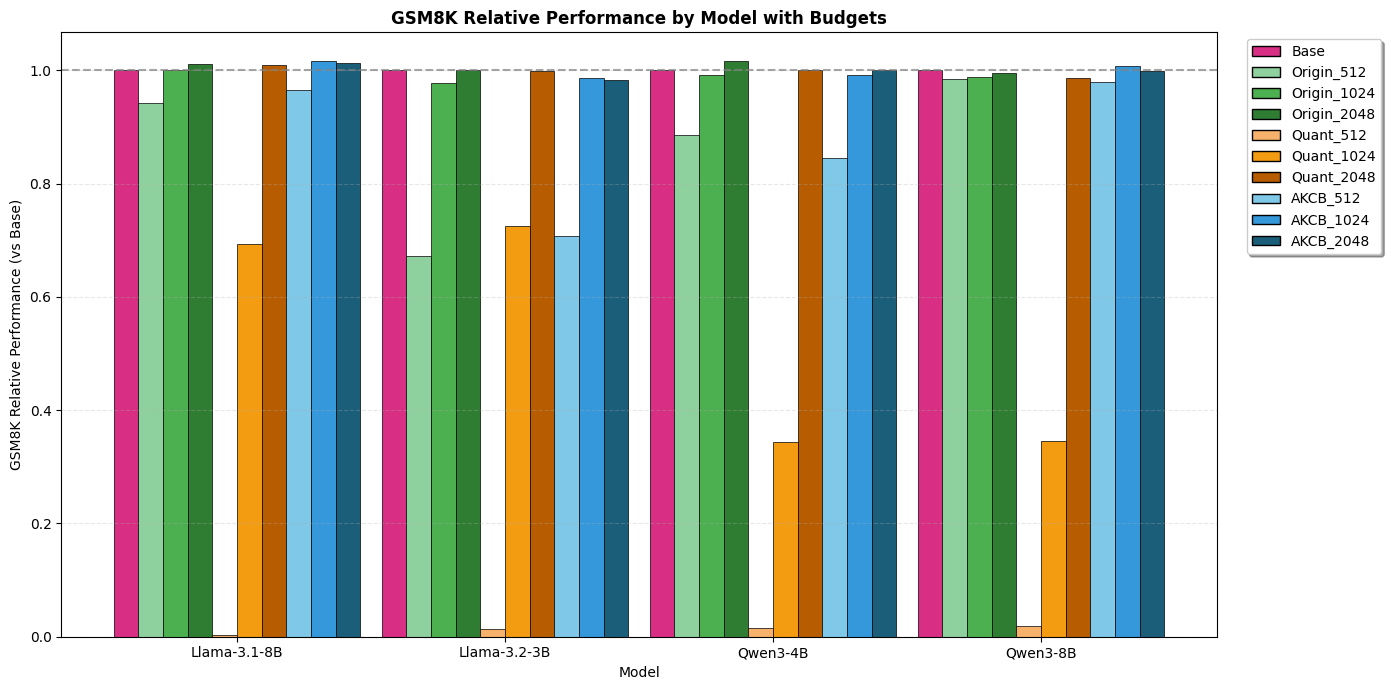

In [14]:
# Combined per-model grouped bar chart with budgets per method
order_cols = [
    'Base',
    'Origin_512', 'Origin_1024', 'Origin_2048',
    'Quant_512', 'Quant_1024', 'Quant_2048',
    'ARKV_512', 'ARKV_1024', 'ARKV_2048'
]
color_map = {
    'Base': MPL_COLORS['Base'],
    'Origin_512': MPL_COLORS['Origin_512'],
    'Origin_1024': MPL_COLORS['Origin_1024'],
    'Origin_2048': MPL_COLORS['Origin_2048'],
    'Quant_512': MPL_COLORS['Quant_512'],
    'Quant_1024': MPL_COLORS['Quant_1024'],
    'Quant_2048': MPL_COLORS['Quant_2048'],
    'ARKV_512': MPL_COLORS['ARKV_512'],
    'ARKV_1024': MPL_COLORS['ARKV_1024'],
    'ARKV_2048': MPL_COLORS['ARKV_2048'],
}

# Build method_budget labels
plot_df = gsm8k_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
model_mb = model_mb.div(model_mb['Base'], axis=0)
model_mb['Base'] = 1.0  # Ensure Base is exactly 1.0

# Ensure all columns in desired order exist
for c in order_cols:
    if c not in model_mb.columns:
        model_mb[c] = np.nan
model_mb = model_mb[order_cols]

# Plot
plt.figure(figsize=(14, 7))
fig, ax = plt.subplots(figsize=(14, 7))
models = list(model_mb.index)
n_bars_per_model = len(order_cols)
bar_width = 0.08
model_spacing = 0.15  # extra gap between model groups

# Compute x positions: consecutive bars per model, then a gap
positions = []
current_x = 0.0
for _ in models:
    # bars for this model
    positions.extend([current_x + i * bar_width for i in range(n_bars_per_model)])
    # add spacing before next model
    current_x = positions[-1] + model_spacing

# Draw bars
colors = [color_map[c] for c in order_cols]
for mi, model in enumerate(models):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    yvals = model_mb.loc[model, order_cols].values
    ax.bar(positions[start:end], yvals, width=bar_width, color=colors,
           edgecolor='black', linewidth=0.5)

# Reference line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# X ticks: put one tick centered under each model group
model_centers = []
for mi in range(len(models)):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    center = np.mean(positions[start:end])
    model_centers.append(center)
ax.set_xticks(model_centers)
ax.set_xticklabels(models, rotation=0)

# Legend: show one patch per column type
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color_map[c], edgecolor='black', label=c) for c in order_cols]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True, shadow=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.title('GSM8K Relative Performance by Model with Budgets', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('GSM8K Relative Performance (vs Base)')
gsm8k_root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/gsm8k')
gsm8k_root.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(gsm8k_root / 'gsm8k_relative_per_model_grouped_budgets.png', dpi=300, bbox_inches='tight')

<Figure size 1400x700 with 0 Axes>

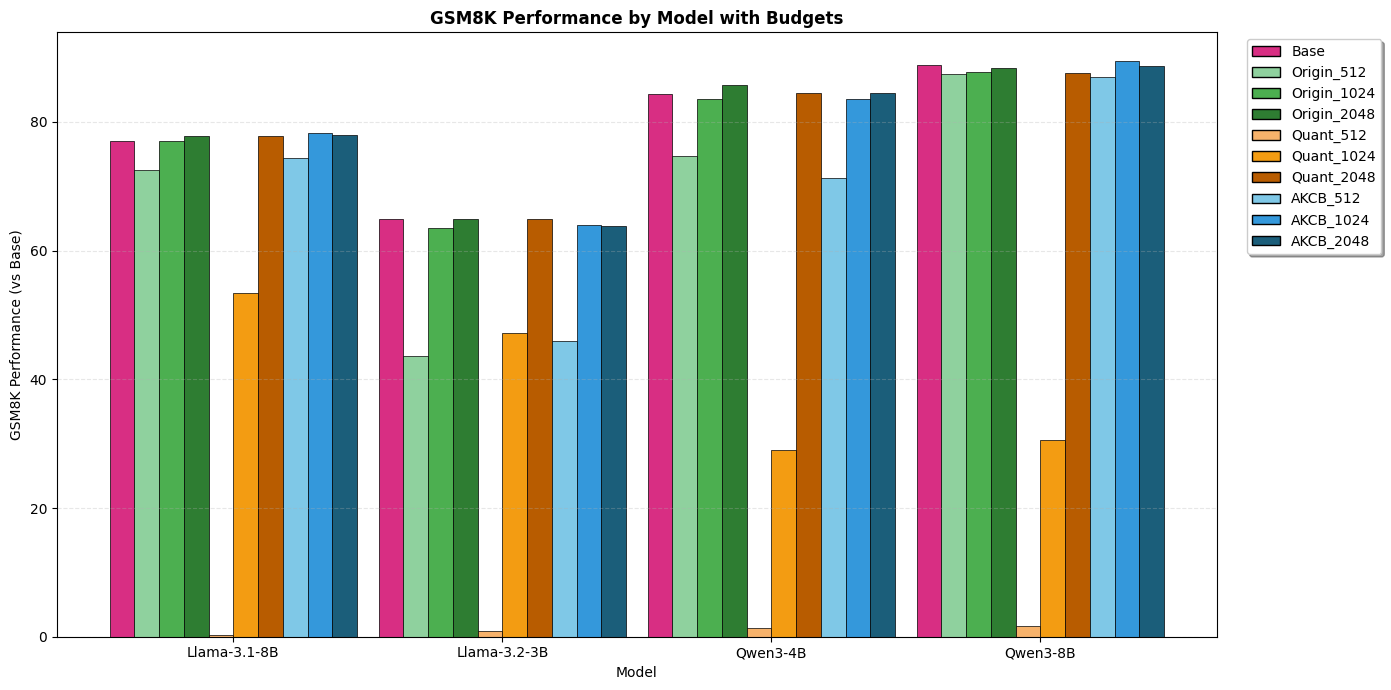

In [15]:
# Combined per-model grouped bar chart with budgets per method
order_cols = [
    'Base',
    'Origin_512', 'Origin_1024', 'Origin_2048',
    'Quant_512', 'Quant_1024', 'Quant_2048',
    'ARKV_512', 'ARKV_1024', 'ARKV_2048'
]
color_map = {
    'Base': MPL_COLORS['Base'],
    'Origin_512': MPL_COLORS['Origin_512'],
    'Origin_1024': MPL_COLORS['Origin_1024'],
    'Origin_2048': MPL_COLORS['Origin_2048'],
    'Quant_512': MPL_COLORS['Quant_512'],
    'Quant_1024': MPL_COLORS['Quant_1024'],
    'Quant_2048': MPL_COLORS['Quant_2048'],
    'ARKV_512': MPL_COLORS['ARKV_512'],
    'ARKV_1024': MPL_COLORS['ARKV_1024'],
    'ARKV_2048': MPL_COLORS['ARKV_2048'],
}

# Build method_budget labels
plot_df = gsm8k_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
# Ensure all columns in desired order exist
for c in order_cols:
    if c not in model_mb.columns:
        model_mb[c] = np.nan
model_mb = model_mb[order_cols]

# Plot
plt.figure(figsize=(14, 7))
fig, ax = plt.subplots(figsize=(14, 7))
models = list(model_mb.index)
n_bars_per_model = len(order_cols)
bar_width = 0.08
model_spacing = 0.15  # extra gap between model groups

# Compute x positions: consecutive bars per model, then a gap
positions = []
current_x = 0.0
for _ in models:
    # bars for this model
    positions.extend([current_x + i * bar_width for i in range(n_bars_per_model)])
    # add spacing before next model
    current_x = positions[-1] + model_spacing

# Draw bars
colors = [color_map[c] for c in order_cols]
for mi, model in enumerate(models):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    yvals = model_mb.loc[model, order_cols].values
    ax.bar(positions[start:end], yvals, width=bar_width, color=colors,
           edgecolor='black', linewidth=0.5)

# Reference line at 1.0
# ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# X ticks: put one tick centered under each model group
model_centers = []
for mi in range(len(models)):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    center = np.mean(positions[start:end])
    model_centers.append(center)
ax.set_xticks(model_centers)
ax.set_xticklabels(models, rotation=0)

# Legend: show one patch per column type
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color_map[c], edgecolor='black', label=c) for c in order_cols]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True, shadow=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.title('GSM8K Performance by Model with Budgets', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('GSM8K Performance (vs Base)')
gsm8k_root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/gsm8k')
gsm8k_root.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(gsm8k_root / 'gsm8k_per_model_grouped_budgets.png', dpi=300, bbox_inches='tight')